Light GBM Model

In [22]:
import os 
import time
import re
from functools import partial
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn import decomposition
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedKFold, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
import optuna
from optuna.samplers import TPESampler
from optuna.trial import TrialState

import lightgbm as lgb
from lightgbm import LGBMRegressor


# LightGBM with all England MSOAs


### Loading and processing data

In [6]:
# load in the data as df
pwd = os.getcwd()
#print(pwd)

data = pd.read_csv(pwd+'\\normalized_percents.csv')

# change all column names to lowercase
data.columns = data.columns.str.lower()

# drop 2001 since income 0 and also drop rows where income is 0
data = data[data['year'] != 2001]
data = data[data['total annual income (£)'] != 0]

#zero = set(data[data['year'] == 2001]['msoa code'].tolist())
one = set(data[data['year'] == 2011]['msoa code'].tolist())
two = set(data[data['year'] == 2021]['msoa code'].tolist())

common_index = one.intersection(two)
mask = data['msoa code'].isin(common_index)
data = data[mask]

# creating summed column of higher occupation for pca score later
occ_pat = '(^occupation:\smanager.*)|(^occupation.*professional.*)'
    
occ_match = re.compile(occ_pat)
co = [c for c in data.columns.tolist() if occ_match.match(c)]

data['higher_occupation'] = data[co].sum(axis=1)

#print(len(data))

# check the column names 
#cols = data.columns.tolist()
#cols # doesn't look like SES score is there
#print(len(data)) 9779 rows in original data

# load the ses scores
#ses_data = pd.read_csv(pwd+'/data/scores.csv')

In [7]:
# scaling - log transform on income and then scaling introduces 82 rows == 0

# set pincode to index
exp1_data = data.set_index('msoa code')
#print(exp1_data.year)

# get log of income and house price
exp1_data['median house price'] = np.log(exp1_data['median house price'])
exp1_data['total annual income (£)'] = np.log(exp1_data['total annual income (£)'])



### Scaling data

In [8]:
# turn the year column into a string
exp1_data['year'] = exp1_data['year'].astype(str)

# get the non-numeric cols
exp1_nonnumeric = exp1_data.select_dtypes(include='object') # has 9779 rows

# get numeric columns only NEED TO EXCLUDE YEAR
exp1_numeric = exp1_data.select_dtypes(include='number')
#print(len(exp1_numeric.columns))
scaler = preprocessing.RobustScaler().fit(exp1_numeric)
exp1_scaled = scaler.transform(exp1_numeric) # still maintains 9779 rows

exp1_numeric = pd.DataFrame(exp1_scaled, index=exp1_numeric.index, columns=exp1_numeric.columns) # 9779 rows
exp1_numeric['year'] = exp1_nonnumeric['year']
#print(exp1_numeric['year'].head())

# merge back into single df
exp1_processed = exp1_nonnumeric.merge(exp1_numeric, how='inner', on=['msoa code', 'year'])

#print(len(exp1_processed))

### Creating SES variable

In [9]:
# creating the df of variables to create ses score

pattern = '(year)|(.*level 4.*)|(.*price.*)|(.*income.*)|(higher_occupation)'
    
m = re.compile(pattern)
cols = [c for c in data.columns.tolist() if m.match(c)]
#print(cols)

ses_vars = exp1_processed[cols]

ses_vars.sort_values(by=['year','msoa code'], ascending=True, inplace=True)
#print(ses_vars.head())


print(ses_vars.head())

           year  \
msoa code         
E02000001  2011   
E02000002  2011   
E02000003  2011   
E02000004  2011   
E02000005  2011   

           highest level of qualification: level 4 qualifications or above  \
msoa code                                                                    
E02000001                                           2.079763                 
E02000002                                          -0.578862                 
E02000003                                          -0.300022                 
E02000004                                          -0.595959                 
E02000005                                          -0.610861                 

           median house price  total annual income (£)  higher_occupation  
msoa code                                                                  
E02000001            1.047336                 1.408548           1.843460  
E02000002           -0.047193                -0.340952          -0.495484  
E02000003      

C:\Users\Teju\AppData\Local\Temp\ipykernel_18688\3307025896.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ses_vars.sort_values(by=['year','msoa code'], ascending=True, inplace=True)


In [10]:
# pca for ses score
ses_np_scaled = ses_vars.drop('year', axis=1).to_numpy()

pca = decomposition.PCA(n_components=1, random_state=16)
pca.fit(ses_np_scaled)

first_comp = pca.transform(ses_np_scaled)

num_msoa_year = len(ses_vars) // 2
#print(type(num_msoa_year))

scores11 = first_comp[ :num_msoa_year]
scores21 = first_comp[num_msoa_year: ]
#scores21 = first_comp[2*num_msoa_year: ]

assert len(scores11) + len(scores21) == len(ses_vars), 'scores and ses_vars differ in num rows'

# change from np arrays to df and add the index
#ses_vars01 = ses_vars[ses_vars['year'] == 2001]
ses_vars11 = ses_vars[ses_vars['year'] == '2011']
ses_vars21 = ses_vars[ses_vars['year'] == '2021']

#scores01 = pd.DataFrame(scores01, index=ses_vars01.index)
#scores01 = scores01.rename(columns={0: 'ses_score'})
scores11 = pd.DataFrame(scores11, index=ses_vars11.index)
scores11 = scores11.rename(columns={0: 'ses_score'})
scores21 = pd.DataFrame(scores21, index=ses_vars21.index)
scores21 = scores21.rename(columns={0: 'ses_score'})

scores_combined = scores11.merge(scores21, how='inner',on='msoa code',suffixes=['_11', '_21'])
#scores_combined = scores_combined.rename(columns={'ses_score':'ses_score_21'})
print(scores_combined.head())

           ses_score_11  ses_score_21
msoa code                            
E02000001      3.060824      3.849733
E02000002     -0.892658     -0.029974
E02000003     -0.298174      0.389150
E02000004     -0.590434      0.403378
E02000005     -0.878350      0.196340


In [11]:
pca.components_

array([[0.53179603, 0.48547477, 0.48680423, 0.4944986 ]])

### Checking the density of SES var

C:\Users\Teju\AppData\Local\Temp\ipykernel_18688\1643501140.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(scores_combined['ses_score_11'], shade=True, ax=axes[0])
c:\Users\Teju\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Teju\AppData\Local\Temp\ipykernel_18688\1643501140.py:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(scores_combined['ses_score_21'], shade=True, ax=axes[1])
c:\Users\Teju\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_in

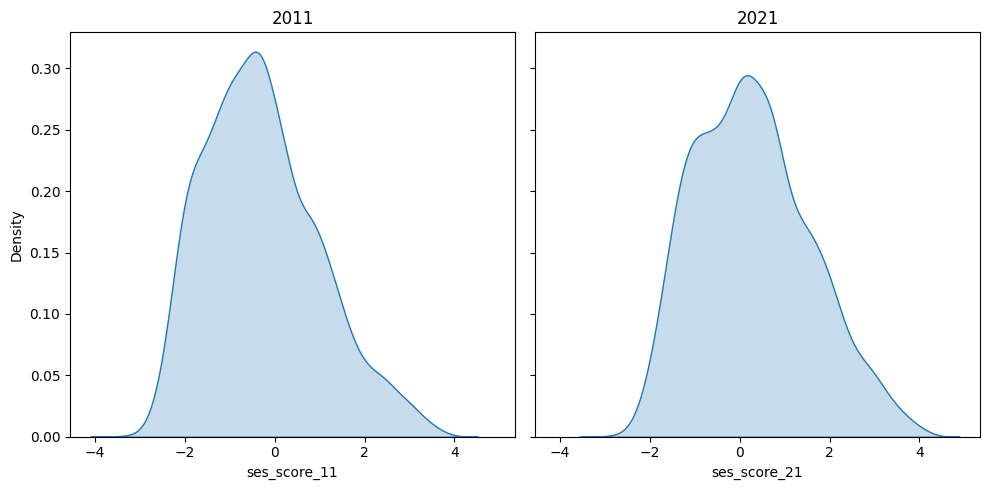

In [12]:
# look at the density of scores each year
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
#sns.kdeplot(scores_combined['ses_score_01'], shade=True, ax=axes[0])
#axes[0].set_title("2001")

sns.kdeplot(scores_combined['ses_score_11'], shade=True, ax=axes[0])
axes[0].set_title("2011")

sns.kdeplot(scores_combined['ses_score_21'], shade=True, ax=axes[1])
axes[1].set_title("2021")

plt.tight_layout()
plt.show()

### Final processing for data splitting and modeling

In [13]:
# takes into account negatives and gives correct change
#scores_combined['ses_diff_01_11'] = scores_combined['ses_score_11'] - scores_combined['ses_score_01']
scores_combined['ses_diff_11_21'] = scores_combined['ses_score_21'] - scores_combined['ses_score_11']

In [14]:
# combine processed data and score 

dep_11_21 = pd.DataFrame(scores_combined['ses_diff_11_21'])
year = pd.DataFrame(['2011']*len(dep_11_21), index=dep_11_21.index)
dep_11_21 = dep_11_21.merge(year, how='inner', on='msoa code')
dep_11_21.rename(columns={'ses_diff_11_21': 'y_var', 0: 'year'}, inplace=True)

# drop 2021 rows in exp1
data_processed = exp1_processed[exp1_processed['year'] != '2021']
#print(len(data_processed.columns))

# drop higher_occupation column from data_processed
data_processed.drop('higher_occupation', axis=1, inplace=True)
#print(len(data_processed.columns))

# combine dependent and ind vars
data_processed = data_processed.merge(dep_11_21, how='inner', on=['msoa code', 'year'])


C:\Users\Teju\AppData\Local\Temp\ipykernel_18688\2095139946.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_processed.drop('higher_occupation', axis=1, inplace=True)


In [15]:
# get 2011 data and do train test split
#data_proc_2001 = data_processed[data_processed['year'] == '2001']

# get the data ready for modeling

# drop the year column
data_processed = data_processed.drop(['year', 'msoa name', 'city code', 'city name'], axis=1)
X = data_processed.loc[:, data_processed.columns != 'y_var'].to_numpy()
y = data_processed['y_var'].to_numpy()

# split data into training and testing 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=386)


### Baseline Light GBM  model

In [31]:

# Create and train the untuned LightGBM model
untuned_lgbm = LGBMRegressor(random_state=73)

# Perform cross-validation to get untuned LightGBM performance metrics
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=75)
mse_untuned_lgbm_cv = cross_val_score(untuned_lgbm, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')
mae_untuned_lgbm_cv = cross_val_score(untuned_lgbm, X_train, y_train, cv=cv, scoring='neg_mean_absolute_error')

mse_untuned_lgbm = np.mean(np.abs(mse_untuned_lgbm_cv))
mae_untuned_lgbm = np.mean(np.abs(mae_untuned_lgbm_cv))

# Make predictions on the test set using the untuned LightGBM model
untuned_lgbm.fit(X_train, y_train)
y_pred_test_lgbm = untuned_lgbm.predict(X_test)

# Compute test set metrics for untuned LightGBM
test_mse_untuned_lgbm = mean_squared_error(y_test, y_pred_test_lgbm)
test_mae_untuned_lgbm = mean_absolute_error(y_test, y_pred_test_lgbm)

# Print untuned LightGBM performance metrics
print(f'Untuned LightGBM 5-fold CV MSE: {mse_untuned_lgbm}')
print(f'Untuned LightGBM 5-fold CV MAE: {mae_untuned_lgbm}\n')
print(f'Test MSE using untuned LightGBM: {test_mse_untuned_lgbm}')
print(f'Test MAE using untuned LightGBM: {test_mae_untuned_lgbm}')



[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009448 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 47365
[LightGBM] [Info] Number of data points in the train set: 1784, number of used features: 201
[LightGBM] [Info] Start training from score 0.594041
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006872 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 47359
[LightGBM] [Info] Number of data points in the train set: 1784, number of used features: 201
[LightGBM] [Info] Start training from score 0.587251
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003776 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 47358
[LightGBM] [Info] Number of data points in the train set: 1784, number of used features: 201
[LightGBM] [Info] Start 

In [20]:
X_train.shape

(2230, 211)

In [37]:
def change_metrics(y_true, y_pred, dataset='Valid'):
    
    # should only pass in numpy arrays
    
    # calculate how many sd away each is for true
    true_mean, true_sd = np.mean(y_true), np.std(y_true)
    true_sd_change = (y_true - true_mean) / true_sd
    
    # for pred calculate how much change
    pred_mean, pred_sd = np.mean(y_pred), np.std(y_pred)
    pred_sd_change = (y_pred - pred_mean) / pred_sd
    
    true_sd_change_cls = true_sd_change >= 1.0
    true_sd_change_cls = true_sd_change_cls.astype(int)
    
    pred_sd_change_cls = pred_sd_change >= 1.0
    pred_sd_change_cls = pred_sd_change_cls.astype(int)
    
    y_acc = accuracy_score(true_sd_change_cls, pred_sd_change_cls)
    y_bacc = balanced_accuracy_score(true_sd_change_cls, pred_sd_change_cls)
    y_f1 = f1_score(true_sd_change_cls, pred_sd_change_cls)

    print(f'{dataset} Accuracy: {y_acc}')
    print(f'{dataset} Balanced Accuracy: {y_bacc}')
    print(f'{dataset} F1: {y_f1}')

In [49]:
#
untuned_lgbm_train_preds = untuned_lgbm.predict(X_train)

untuned_lgbm_test_preds = untuned_lgbm.predict(X_test)

# train performance

change_metrics(y_train, untuned_lgbm_train_preds, dataset='Train')

# test performance

change_metrics(y_test, untuned_lgbm_test_preds)

Train Accuracy: 0.9690582959641255
Train Balanced Accuracy: 0.9424879745259482
Train F1: 0.8926905132192846
Valid Accuracy: 0.8871473354231975
Valid Balanced Accuracy: 0.778719811436914
Valid F1: 0.6170212765957447


### LGBM hyperparameter tuning

In [28]:
# hyperparameter tuning setup for lightgbm

# Different types of boosting algorithms to use with LightGBM. Options include gbdt (Gradient Boosting Decision Tree), dart (Dropouts meet Multiple Additive Regression Trees), goss (Gradient-based One-Side Sampling), and rf (Random Forest)
boosting_type= ['gbdt', 'dart', 'goss', 'rf']

#The learning rate or shrinkage rate controls the step size during boosting.
learning_rate= [0.01, 0.05, 0.1]

# Number of trees in random forest
n_estimators= [int(x) for x in np.linspace(start=100, stop=1000, num=10)]


# Maximum number of levels in tree
max_depth= [int(x) for x in np.linspace(10, 110, num=11)] + [None]


# The maximum number of leaves in each tree.
num_leaves = [20, 30, 40]

# Minimum number of samples required to form a new node in the tree.
min_child_samples= [2, 5, 10]

# Fraction of samples used for training each tree
subsample= [0.6, 0.8, 1.0]

#Fraction of features used for training each tree
colsample_bytree= [0.6,0.8, 1.0]



# Create the hyperparameter grid for LightGBM
param_grid = {
    'boosting_type': boosting_type,
    'learning_rate': learning_rate,
    'n_estimators': n_estimators,
    'max_depth': max_depth,
    'num_leaves': num_leaves,
    'min_child_samples': min_child_samples,
    'subsample': subsample,
    'colsample_bytree': colsample_bytree,
    
}

In [30]:

# Create the LightGBM regressor model
lgbm_model = LGBMRegressor(random_state=386)

# Search across 100 different combinations, and use all available cores
tuned_lgbm = RandomizedSearchCV(estimator=lgbm_model, param_distributions=param_grid, 
                                n_iter=100, cv=5, verbose=2, random_state=386, n_jobs=-1)

# Fit the random search model
tuned_lgbm.fit(X_train, y_train)

# Get the best parameters and best score
best_params = tuned_lgbm.best_params_
best_score = tuned_lgbm.best_score_

print("Best parameters:", best_params)
print("Best score:", best_score)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


c:\Users\Teju\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
25 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Teju\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Teju\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\sklearn.py", line 1092, in fit
    super().fit(
  File "c:\Users\Teju\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\sklearn.py", line 885, in

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004733 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 47600
[LightGBM] [Info] Number of data points in the train set: 2230, number of used features: 201
[LightGBM] [Info] Start training from score 0.587052
Best parameters: {'subsample': 1.0, 'num_leaves': 20, 'n_estimators': 600, 'min_child_samples': 10, 'max_depth': 100, 'learning_rate': 0.1, 'colsample_bytree': 0.6, 'boosting_type': 'dart'}
Best score: 0.5677889742712625


In [32]:
# tuned lightgbm and predictions
optimal_lgbm = LGBMRegressor(subsample=1.0, num_leaves= 20, n_estimators= 600, min_child_samples= 10, max_depth= 100, learning_rate= 0.1, colsample_bytree= 0.6, boosting_type= 'dart')
     
optimal_lgbm.fit(X_train, y_train)

y_pred_tune_lgbm = optimal_lgbm.predict(X_test)

y_pred_tune_lgbm_mean = np.mean(y_pred_tune_lgbm)
y_pred_tune_lgbm_sd = np.std(y_pred_tune_lgbm)

tune_lgbm_pred_std_away = (y_pred_tune_lgbm - y_pred_tune_lgbm_mean) / y_pred_tune_lgbm_sd

tune_lgbm_mse = mean_squared_error(y_test, y_pred_tune_lgbm)
tune_lgbm_mae = mean_absolute_error(y_test, y_pred_tune_lgbm)

print(f'Tuned LGBM MSE: {tune_lgbm_mse}\nTuned LGBM MAE: {tune_lgbm_mae}')

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003600 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 47600
[LightGBM] [Info] Number of data points in the train set: 2230, number of used features: 201
[LightGBM] [Info] Start training from score 0.587052
Tuned LGBM MSE: 0.028132734991935224
Tuned LGBM MAE: 0.1267270661485815


In [50]:


optimal_lgbm_train_preds = optimal_lgbm.predict(X_train)

optimal_lgbm_test_preds = optimal_lgbm.predict(X_test)

# train performance

change_metrics(y_train, optimal_lgbm_train_preds, dataset='Train')

# test performance

change_metrics(y_test, optimal_lgbm_test_preds)

Train Accuracy: 0.973542600896861
Train Balanced Accuracy: 0.9477335052710906
Train F1: 0.9073783359497645
Valid Accuracy: 0.8881922675026124
Valid Balanced Accuracy: 0.7823169337390723
Valid F1: 0.6219081272084805


Sampling with optuna

In [35]:
# setting up the objective function of hyperopt

def objective(trial):
    

    lgbm_params = {
        'verbosity': -1,
        'boost_from_average': True,
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.5, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_child_weight': trial.suggest_float('min_child_weight', 0.1, 100.0, log=True),
        'subsample': trial.suggest_float('subsample', 0.4, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-9, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-9, 10.0, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 100, 2000, 100),
        'n_jobs': -1  # Utilize all available CPU cores
    }
    
    # init model
    lgbm = lgb.LGBMRegressor(**lgbm_params)
    
    #rf.fit(X_train, y_train)
    
    cv = RepeatedKFold(n_splits=5, n_repeats=1, random_state=75)
    mse = cross_val_score(lgbm, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')
    
    return -mse.mean()

In [36]:

sampler = TPESampler(seed=440)
lgbm_study = optuna.create_study(direction='minimize', sampler=sampler)
lgbm_study.optimize(objective, n_trials=150, timeout=600)

print("Best Trial:")
lgbm_trial = lgbm_study.best_trial

print("  Params: ")
for key, value in lgbm_study.best_trial.params.items():
    print("    {}: {}".format(key, value))


[I 2024-04-17 07:07:44,830] A new study created in memory with name: no-name-822c1365-a1c9-48df-96c7-00a4d121f8d9
C:\Users\Teju\AppData\Local\Temp\ipykernel_18688\1401132996.py:17: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 100, 2000, 100),
[I 2024-04-17 07:08:33,494] Trial 0 finished with value: 0.029544140618537357 and parameters: {'learning_rate': 0.011032838875693998, 'num_leaves': 248, 'max_depth': 18, 'min_child_weight': 1.5630945140684644, 'subsample': 0.7696884989119741, 'colsample_bytree': 0.7774234491598055, 'reg_alpha': 3.377327433443182e-08, 'reg_lambda': 5.625350073531997e-08, 'n_estimators': 800}. Best is trial 0 with value: 0.029544140618537357.
C:\Users\Teju\AppData\Local\Temp\ipykernel_18688\1401132996.py:17: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_esti

Best Trial:
  Params: 
    learning_rate: 0.022801321090440696
    num_leaves: 139
    max_depth: 7
    min_child_weight: 1.7421693912806686
    subsample: 0.5655301924776361
    colsample_bytree: 0.46378056904051224
    reg_alpha: 3.3251592865308267e-08
    reg_lambda: 1.7265985011463995e-09
    n_estimators: 1800


### Optimal RF model performance

In [38]:
lgbm_best_trial = lgbm_study.best_trial.params
lgbm_best_trial

{'learning_rate': 0.022801321090440696,
 'num_leaves': 139,
 'max_depth': 7,
 'min_child_weight': 1.7421693912806686,
 'subsample': 0.5655301924776361,
 'colsample_bytree': 0.46378056904051224,
 'reg_alpha': 3.3251592865308267e-08,
 'reg_lambda': 1.7265985011463995e-09,
 'n_estimators': 1800}

In [39]:
# training and testing prediction

opt_lgbm = LGBMRegressor(**lgbm_best_trial).fit(X_train, y_train)

lgbm_train_preds = opt_lgbm.predict(X_train)

lgbm_test_preds = opt_lgbm.predict(X_test)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003475 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 47600
[LightGBM] [Info] Number of data points in the train set: 2230, number of used features: 201
[LightGBM] [Info] Start training from score 0.587052
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

In [40]:
# train performance

change_metrics(y_train, lgbm_train_preds, dataset='Train')

Train Accuracy: 0.9946188340807175
Train Balanced Accuracy: 0.9876521426533712
Train F1: 0.9810126582278481


In [41]:
# test performance

change_metrics(y_test, lgbm_test_preds)

Valid Accuracy: 0.8923719958202717
Valid Balanced Accuracy: 0.7907336722309194
Valid F1: 0.6360424028268551


In [43]:
def lgbm_obj2(trial):
    
    lgbm_params = {
        'verbosity': -1,
        'boost_from_average': True,
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.5, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_child_weight': trial.suggest_float('min_child_weight', 0.1, 100.0, log=True),
        'subsample': trial.suggest_float('subsample', 0.4, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-9, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-9, 10.0, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 100, 2000, 100),
        'n_jobs': -1  # Utilize all available CPU cores
    }
    
    # init model
    lgbm = lgb.LGBMRegressor(**lgbm_params)
    
    
    #rf.fit(X_train, y_train)
    
    cv = RepeatedKFold(n_splits=5, n_repeats=1, random_state=75)
    mse = cross_val_score(lgbm, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')
    
    return -mse.mean()

In [44]:
lgbm2_study = optuna.create_study(direction='minimize', sampler=sampler)
lgbm2_study.optimize(lgbm_obj2, n_trials=150, timeout=600)

print("Best Trial:")
lgbm2_trial = lgbm2_study.best_trial

lgbm2_best_trial = lgbm2_study.best_trial.params
lgbm2_best_trial

[I 2024-04-17 07:25:39,080] A new study created in memory with name: no-name-aedd3717-a7eb-4827-9bf1-fd70cc79f485
C:\Users\Teju\AppData\Local\Temp\ipykernel_18688\669464850.py:14: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators', 100, 2000, 100),
[I 2024-04-17 07:26:13,631] Trial 0 finished with value: 0.028814193509755347 and parameters: {'learning_rate': 0.01179008106333838, 'num_leaves': 116, 'max_depth': 7, 'min_child_weight': 3.3438924534645316, 'subsample': 0.7546904845971003, 'colsample_bytree': 0.5517741616442702, 'reg_alpha': 0.10310818422095279, 'reg_lambda': 1.1917241329798245e-05, 'n_estimators': 1500}. Best is trial 0 with value: 0.028814193509755347.
C:\Users\Teju\AppData\Local\Temp\ipykernel_18688\669464850.py:14: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimato

Best Trial:


{'learning_rate': 0.021859147144660432,
 'num_leaves': 158,
 'max_depth': 5,
 'min_child_weight': 6.592861984807726,
 'subsample': 0.5746968619241397,
 'colsample_bytree': 0.4531015732026657,
 'reg_alpha': 1.2336932771389755,
 'reg_lambda': 2.5751872710458342e-06,
 'n_estimators': 1500}

In [45]:
# training and testing prediction

opt_lgbm2 = LGBMRegressor(**lgbm2_best_trial).fit(X_train, y_train)

lgbm2_train_preds = opt_lgbm2.predict(X_train)

lgbm2_test_preds = opt_lgbm2.predict(X_test)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003408 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 47600
[LightGBM] [Info] Number of data points in the train set: 2230, number of used features: 201
[LightGBM] [Info] Start training from score 0.587052
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

In [46]:
# train performance

change_metrics(y_train, lgbm2_train_preds, dataset='Train')

Train Accuracy: 0.9681614349775785
Train Balanced Accuracy: 0.939333400393456
Train F1: 0.8892355694227769


In [48]:
# test performance

change_metrics(y_test, lgbm2_test_preds)

Valid Accuracy: 0.896551724137931
Valid Balanced Accuracy: 0.8051221614395525
Valid F1: 0.6550522648083623


# SHAP

In [51]:
!pip install shap

   ---------------------------------------- 0.0/453.1 kB ? eta -:--:--
   --------------------------------------  450.6/453.1 kB 14.2 MB/s eta 0:00:01
   ---------------------------------------- 453.1/453.1 kB 9.4 MB/s eta 0:00:00


In [52]:
import shap

In [53]:
tmp_2021 = exp1_processed[exp1_processed['year'] == '2021']
tmp_2021 = tmp_2021.drop(['year', 'msoa name', 'city code', 'city name'], axis=1)

predict_2011 = data_processed.loc[:, data_processed.columns != 'y_var']
predict_2021 = tmp_2021.loc[:, data_processed.columns != 'y_var']

In [54]:
shap_values_2011 = shap.TreeExplainer(opt_lgbm2).shap_values(predict_2011)

In [55]:
shap_values_2021 = shap.TreeExplainer(opt_lgbm2).shap_values(predict_2021)

In [56]:
y_pred_2011 = opt_lgbm2.predict(predict_2011)
y_pred_2021 = opt_lgbm2.predict(predict_2021)

In [57]:
def sd_change(y):
    
    # should only pass in numpy arrays
    
    # calculate how many sd away each is for true
    mean, sd = np.mean(y), np.std(y)
    sd_change = (y - mean) / sd
    
    
    sd_change_cls = sd_change >= 1.0
    sd_change_cls = sd_change_cls.astype(int)
    
    return sd_change, sd_change_cls

In [58]:
sd_change_2011, gentrified_2011 = sd_change(y_pred_2011)
sd_change_2021, gentrified_2021 = sd_change(y_pred_2021)

sd_change_2011_df = pd.DataFrame(sd_change_2011, index=predict_2011.index, columns=['sd_change'])
gentrified_2011_df = pd.DataFrame(gentrified_2011, index=predict_2011.index, columns=['gentrified_ind'])

sd_change_2021_df = pd.DataFrame(sd_change_2021, index=predict_2021.index, columns=['sd_change'])
gentrified_2021_df = pd.DataFrame(gentrified_2021, index=predict_2021.index, columns=['gentrified_ind'])

print(sd_change_2011_df.head())

           sd_change
msoa code           
E02000001  -0.333811
E02000002   1.400041
E02000003   1.102093
E02000004   1.610525
E02000005   1.943782


In [59]:
shap_df_2011 = pd.DataFrame(shap_values_2011, index=predict_2011.index, columns=predict_2011.columns)
shap_df_2021 = pd.DataFrame(shap_values_2021, index=predict_2021.index, columns=predict_2021.columns)

print(shap_df_2011.head())

           age: 0 to 4  age: 10 to 14  age: 15 to 19  age: 16 years and over  \
msoa code                                                                      
E02000001    -0.001566       0.000974      -0.002108                0.007836   
E02000002     0.001847      -0.000822      -0.002622                0.000102   
E02000003     0.001271      -0.000622      -0.002643                0.008328   
E02000004    -0.001528      -0.000313       0.006371               -0.001438   
E02000005     0.001845      -0.000873       0.007872                0.007032   

           age: 20 to 24  age: 25 to 29  age: 30 to 44  age: 45 to 59  \
msoa code                                                               
E02000001       0.001322      -0.001308       0.001152       0.001015   
E02000002      -0.000085      -0.002570      -0.002031      -0.003806   
E02000003       0.000780      -0.002087       0.002961       0.002155   
E02000004       0.001830      -0.002276      -0.001436       0.000258   
E

In [60]:
def top_vars_df(df):

    # df in final form as a placeholder to concatenate  
    vals_df = pd.DataFrame(np.zeros((1,5)), columns=['val1', 'val2', 'val3', 'val4', 'val5'])
    vars_df = pd.DataFrame(np.zeros((1,5)), columns=['var1', 'var2', 'var3','var4', 'var5']).astype(str)
    final_df = pd.concat([vals_df, vars_df], axis=1)

    msoa = df.index.tolist()
    # for each row in df
    for r in range(len(df)):
        # turn row into dataframe with cols as index and vals in cells
        tmp = pd.DataFrame(df.iloc[r, :], index=df.columns)
        # sort by abs of values - index by default also sorted
        tmp = tmp.sort_values(msoa[r], ascending=False, key=abs)
        # subset to top 5 values
        tmp = tmp.iloc[:5, :]
        
        # turn vals and index into a dfs
        vals = pd.DataFrame(tmp.to_numpy().reshape(1,len(tmp)))
        cols = pd.DataFrame(tmp.index.to_numpy().reshape(1, len(tmp)))
            
        
        # column concat 
        row = pd.concat([vals, cols], axis=1)
        row.columns = final_df.columns
        # concat to final df row-wise
        final_df = pd.concat([final_df, row], axis=0, ignore_index=True)
    
    # drop the first 
    final_df = final_df.iloc[1: , [0, 5, 1, 6, 2, 7, 3, 8, 4, 9]]
    final_df.set_index(df.index, inplace=True)
    
    return final_df

In [61]:
# transforming df to top 5 features and values
sorted_2011 = top_vars_df(shap_df_2011)

In [62]:
sorted_2021 = top_vars_df(shap_df_2021)

In [63]:
to_export_2011 = sorted_2011.merge(sd_change_2011_df, how='inner', on='msoa code').merge(gentrified_2011_df, how='inner', on='msoa code')
to_export_2021 = sorted_2021.merge(sd_change_2021_df, how='inner', on='msoa code').merge(gentrified_2021_df, how='inner', on='msoa code')


to_export_2011.to_csv('predictions_on_2011.csv')
to_export_2021.to_csv('predictions_on_2021.csv')